# Movie Genre Classification
**Objective: Create an ML model to predict movie genres based on plot summaries or other textual data.** \
**Model Used: Support Vector Machines (SVM)**

## Importing Libraries
Importing All required Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

## Data Preparation
- Load the dataset into a DataFrame.

In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od

In [4]:
dataset = 'https://www.kaggle.com/datasets/hijest/genre-classification-dataset-imdb/data'

In [5]:
od.download(dataset)

Skipping, found downloaded files in ".\genre-classification-dataset-imdb" (use force=True to force download)


In [6]:
import os

In [7]:
data_dir = './genre-classification-dataset-imdb'

In [8]:
os.listdir(data_dir)

['Genre Classification Dataset']

In [9]:
import pandas as pd

# Load the training data
train_data = pd.read_csv('train_data.txt', sep=' ::: ', header=None, engine='python')
train_data.columns = ['ID', 'Title', 'Genre', 'Description']

# Load the test data
test_data = pd.read_csv('test_data.txt', sep=' ::: ', header=None, engine='python')
test_data.columns = ['ID', 'Title', 'Description']

# Optional: Load the test data solution if needed
test_data_solution = pd.read_csv('test_data_solution.txt', sep=' ::: ', header=None, engine='python')
test_data_solution.columns = ['ID', 'Title', 'Some_Column', 'Genre']


# Display the first few rows of the training data
train_data.head()


,ID,Title,Genre,Description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...


### Checking for Null values

In [10]:
train_data.isnull().sum()

ID             0
Title          0
Genre          0
Description    0
dtype: int64

**Since there no null values, We are going to next step**

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           54214 non-null  int64 
 1   Title        54214 non-null  object
 2   Genre        54214 non-null  object
 3   Description  54214 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [12]:
train_data.describe()

,ID
count,54214.000000
mean,27107.500000
std,15650.378084
min,1.000000
25%,13554.250000
50%,27107.500000
75%,40660.750000
max,54214.000000


In [13]:
Class_Distribution = train_data['Genre'].value_counts()

In [14]:
print("Class_Distribution: ",Class_Distribution)

Class_Distribution:  Genre
drama          13613
documentary    13096
comedy          7447
short           5073
horror          2204
thriller        1591
action          1315
western         1032
reality-tv       884
family           784
adventure        775
music            731
romance          672
sci-fi           647
adult            590
crime            505
animation        498
sport            432
talk-show        391
fantasy          323
mystery          319
musical          277
biography        265
history          243
game-show        194
news             181
war              132
Name: count, dtype: int64


**Since we listed the number of types of genre, Let's dive into next step**

In [15]:
# Check the unique genres in the training data
unique_genres = train_data['Genre'].unique()
print(unique_genres)


['drama' 'thriller' 'adult' 'documentary' 'comedy' 'crime' 'reality-tv'
 'horror' 'sport' 'animation' 'action' 'fantasy' 'short' 'sci-fi' 'music'
 'adventure' 'talk-show' 'western' 'family' 'mystery' 'history' 'news'
 'biography' 'romance' 'game-show' 'musical' 'war']


**Since we listed the unique types of genre,Let's dive into next step**

### Checking for Duplicate Entries
After ensuring there are no null values, the next step is to check for duplicate entries in the dataset. Duplicate data can skew the model's performance, so it is important to identify and remove them if present.


In [16]:
# Check for duplicate rows in the training data
duplicate_rows = train_data[train_data.duplicated()]

# Print the number of duplicate rows found
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

# Display the duplicate rows, if any
if not duplicate_rows.empty:
    print(duplicate_rows)
else:
    print("No duplicate rows found.")


Number of duplicate rows: 0
No duplicate rows found.


### Remove Special Characters
Clean the description column by removing special characters, numbers, and unnecessary punctuation.

In [17]:
import re

def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Apply cleaning function to the 'description' column
train_data['Description'] = train_data['Description'].apply(clean_text)
test_data['Description'] = test_data['Description'].apply(clean_text)


In [18]:
train_data.head()

,ID,Title,Genre,Description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The films title refers not only to the unrecov...


### Convert to Lowercase
Convert all text to lowercase to ensure uniformity.

In [19]:
train_data['Description'] = train_data['Description'].str.lower()
test_data['Description'] = test_data['Description'].str.lower()


In [20]:
train_data.head()

,ID,Title,Genre,Description
0,1,Oscar et la dame rose (2009),drama,listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,a brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,as the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,to help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,the films title refers not only to the unrecov...


### Visual Representation
Displaying the data as graphs

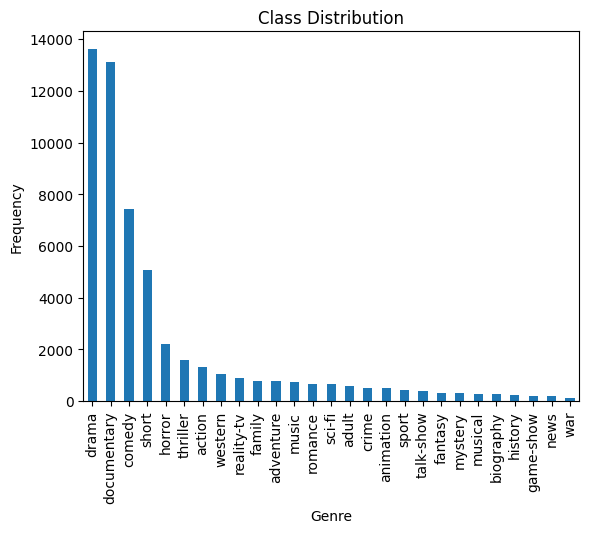

In [21]:
Class_Distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.show()

In [22]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_data['Description'])
y_train = train_data['Genre']

### Training the model

In [23]:
MultinomialNB = MultinomialNB()

In [24]:
MultinomialNB.fit(X_train,y_train)

MultinomialNB()

### Predicting the Output

In [25]:
y_train_pred = MultinomialNB.predict(X_train)

In [26]:
y_train_pred

array(['drama', 'drama', 'documentary', ..., 'comedy', 'comedy',
       'documentary'], dtype='<U11')

### Checking the Metrics

In [27]:
print("Accuracy: ", accuracy_score(y_train,y_train_pred))

Accuracy:  0.5343453720441215


In [28]:
print("Classification Report: ", classification_report(y_train,y_train_pred,zero_division=1))

Classification Report:                precision    recall  f1-score   support

      action       0.72      0.09      0.16      1315
       adult       0.82      0.05      0.09       590
   adventure       0.75      0.06      0.11       775
   animation       1.00      0.00      0.00       498
   biography       1.00      0.00      0.00       265
      comedy       0.56      0.45      0.50      7447
       crime       1.00      0.00      0.00       505
 documentary       0.57      0.90      0.70     13096
       drama       0.46      0.84      0.60     13613
      family       1.00      0.00      0.01       784
     fantasy       1.00      0.00      0.00       323
   game-show       1.00      0.13      0.24       194
     history       1.00      0.00      0.00       243
      horror       0.78      0.36      0.49      2204
       music       0.91      0.15      0.26       731
     musical       1.00      0.00      0.00       277
     mystery       1.00      0.00      0.00       319
   

### Predicting for text data

In [29]:
X_test = vectorizer.fit_transform(test_data['Description'])

In [30]:
X_test_pred = MultinomialNB.predict(X_test)

In [31]:
test_data['Predicted_Genre'] = X_test_pred

In [32]:
test_data.to_csv('test_data_prd.csv',index = False)

In [33]:
print(test_data)

          ID                           Title  \
0          1            Edgar's Lunch (1998)   
1          2        La guerra de papá (1977)   
2          3     Off the Beaten Track (2010)   
3          4          Meu Amigo Hindu (2015)   
4          5               Er nu zhai (1955)   
...      ...                             ...   
54195  54196  "Tales of Light & Dark" (2013)   
54196  54197     Der letzte Mohikaner (1965)   
54197  54198             Oliver Twink (2007)   
54198  54199               Slipstream (1973)   
54199  54200       Curitiba Zero Grau (2010)   

                                             Description Predicted_Genre  
0      lr brane loves his life  his car his apartment...           short  
1      spain march  quico is a very naughty child of ...          comedy  
2      one year in the life of albin and his family o...          comedy  
3      his father has died he hasnt spoken with his b...           drama  
4      before he was known internationally as a 

### Hyperparameter Tuning

In [34]:
param_grid = {'alpha': [0.00001,0.0001,0.001,0.5, 1.0, 2.0]}

In [35]:
grid_search = GridSearchCV(estimator=MultinomialNB, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.5, 1.0, 2.0]},
             scoring='accuracy')

In [36]:
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'alpha': 0.001}


In [37]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.5994


### Conclusion

This project is done by **Thota Rahul**